In [4]:
%pip install ultralytics pandas opencv-python Pillow matplotlib

%pip install roboflow

import os
import yaml
import shutil
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
from roboflow import Roboflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- Roboflow Setup (Keep your API key securely) ---
# 🔑 Use the NEW API key you just generated
rf = Roboflow(api_key="ZG6wAq6WO6sA0rAIZy7K") 
project = rf.workspace("tps-klzw4").project("path-oj7sc")
version = project.version(1)

# This command downloads the ZIP and automatically extracts it 
# into a new folder named based on the project/version (e.g., 'path-oj7sc-1')
print("Starting fresh dataset download...")
dataset = version.download("yolov5") 

# The 'dataset' object now holds the name of the newly created folder
NEW_DATASET_ROOT = dataset.location 
print(f"✅ Download and extraction complete. New folder name is: {NEW_DATASET_ROOT}")


loading Roboflow workspace...
loading Roboflow project...
Starting fresh dataset download...
✅ Download and extraction complete. New folder name is: /Users/sc/Desktop/GP/Arva-Autonomous-Robotic-System-for-Smart-Agriculture/Python/Road Segmentation/path-1


In [5]:
# Set DATASET_ROOT to the exact, correct folder name.
DATASET_ROOT = 'path-1' 
MODEL_NAME = 'yolov8s-seg.pt' 

# Training parameters
EPOCHS = 75
BATCH_SIZE = 8
IMAGE_SIZE = 640 

DEVICE = 'cpu'


# --- 1. Define Dataset Structure and Classes ---
CLASS_NAMES = ['path']
NUM_CLASSES = len(CLASS_NAMES)

# Define the paths for the YAML file
YAML_FILE_PATH = 'dataset.yaml'

# --- 2. Create the Custom Dataset YAML File ---
# This ensures the absolute path ('path') uses the corrected DATASET_ROOT
print(f"Creating custom dataset YAML file: {YAML_FILE_PATH}")

dataset_yaml_content = {
    'path': os.path.abspath(DATASET_ROOT),  # **Uses 'path-1'**
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': NUM_CLASSES,
    'names': CLASS_NAMES
}

# Write the YAML content to a file, overwriting the old one
with open(YAML_FILE_PATH, 'w') as f:
    yaml.dump(dataset_yaml_content, f, default_flow_style=False)

print(f"Dataset YAML file created successfully. Absolute path set to: {os.path.abspath(DATASET_ROOT)}")
print("-" * 50)

# --- 3. Load the YOLO-Seg Model ---
print(f"Loading YOLOv8 Segmentation Model: {MODEL_NAME}")
try:
    model = YOLO(MODEL_NAME)
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure you have the 'ultralytics' library installed: pip install ultralytics")
    exit()

# --- 4. Train the Model ---
# The model will now read the correctly generated dataset.yaml
print(f"Starting model training for {EPOCHS} epochs...")

results = model.train(
data=YAML_FILE_PATH,
    epochs=EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    device=DEVICE,
    name='path_segmentation_run_s_opt', # New run name
    project='runs/segment',
    workers=1,              # Performance Fix: Use 1 worker to prevent common Dataloader bottlenecks
    # Optimized Augmentations for blur/stretch:
    hsv_v=0.6,              # Increased Brightness/Value jitter (combats lighting issues/blur)
    degrees=5.0,            # Added mild rotation to generalize perspective
    shear=5.0               # Added mild shear/perspective distortion
)

print("-" * 50)
print("Training finished.")


# NOTE: We assume SAVE_DIR is already defined by the model.train() call
SAVE_DIR = model.trainer.save_dir
RESULTS_PATH = os.path.join(SAVE_DIR, 'results.csv')
print(f"Results saved to: {RESULTS_PATH}")



Creating custom dataset YAML file: dataset.yaml
Dataset YAML file created successfully. Absolute path set to: /Users/sc/Desktop/GP/Arva-Autonomous-Robotic-System-for-Smart-Agriculture/Python/Road Segmentation/path-1
--------------------------------------------------
Loading YOLOv8 Segmentation Model: yolov8s-seg.pt
Starting model training for 75 epochs...
New https://pypi.org/project/ultralytics/8.3.248 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.233 🚀 Python-3.12.4 torch-2.9.1 CPU (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=5.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fr

KeyboardInterrupt: 

Note: you may need to restart the kernel to use updated packages.
🚀 Generating Analysis Charts and Tables...

--- FINAL EPOCH METRICS SUMMARY (Validation Set) ---
Box mAP@50     : 0.9407
Mask mAP@50    : 0.9330
Mask mAP@50-95 : 0.6118
Val Box Loss   : 1.0212
Val Seg Loss   : 1.6384
-----------------------------------------------------


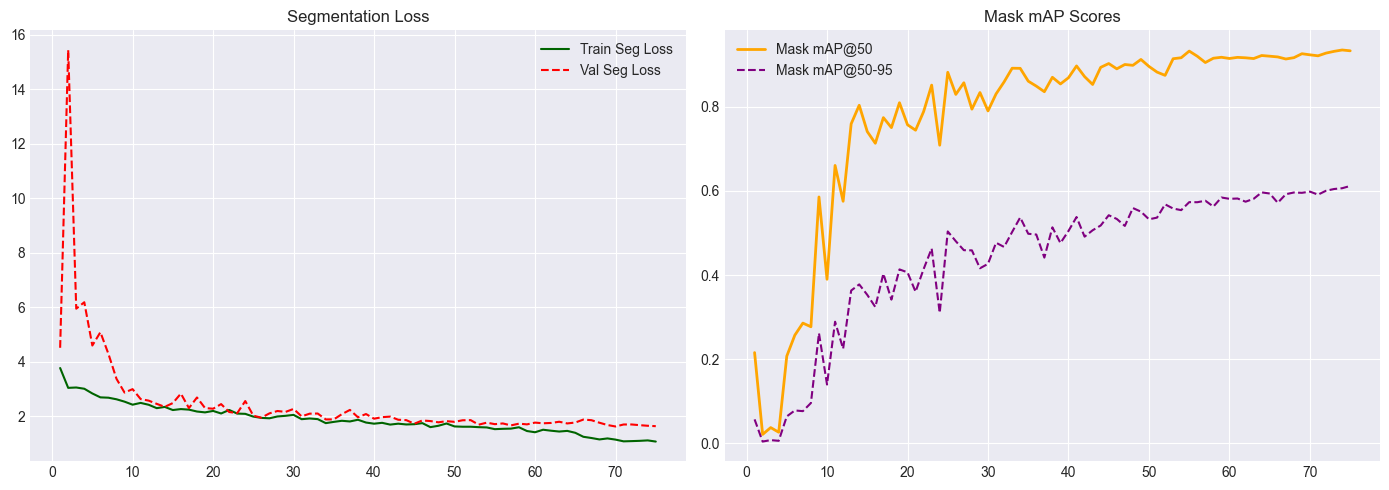

In [11]:
# --- 5. Analysis and Visualization (UPDATED AND CORRECTED) ---

# Retrieve RESULTS_PATH based on the training run directory (no join)
%pip install tabulate

# --- 5. Analysis and Visualization (ROBUST VERSION) ---
import pandas as pd
import matplotlib.pyplot as plt
import os

RESULTS_PATH = "runs/segment/path_segmentation_run_s_opt7/results.csv"

print("🚀 Generating Analysis Charts and Tables...")

try:
    df = pd.read_csv(
        RESULTS_PATH,
        sep=r', *',
        engine='python',
        comment='#',
        skipinitialspace=True
    )

    # Clean up column names
    df.columns = df.columns.str.strip()
    
    # --- HELPER: Flexible Column Finder ---
    def find_col(keywords):
        for col in df.columns:
            if all(k in col for k in keywords):
                return col
        return None

    # Map the columns dynamically
    c_box_50  = find_col(['metrics', 'mAP50(B)']) or find_col(['metrics', 'mAP50(box)'])
    c_mask_50 = find_col(['metrics', 'mAP50(M)']) or find_col(['metrics', 'mAP50(mask)'])
    c_mask_95 = find_col(['metrics', 'mAP50-95(M)']) or find_col(['metrics', 'mAP50-95(mask)'])
    c_val_box_loss = find_col(['val', 'box_loss'])
    c_val_seg_loss = find_col(['val', 'seg_loss'])

    # --- 5a. Final Metrics Table ---
    print("\n--- FINAL EPOCH METRICS SUMMARY (Validation Set) ---")
    
    final_metrics = {
        'Box mAP@50': df[c_box_50].iloc[-1] if c_box_50 else "N/A",
        'Mask mAP@50': df[c_mask_50].iloc[-1] if c_mask_50 else "N/A", 
        'Mask mAP@50-95': df[c_mask_95].iloc[-1] if c_mask_95 else "N/A",
        'Val Box Loss': df[c_val_box_loss].iloc[-1] if c_val_box_loss else "N/A",
        'Val Seg Loss': df[c_val_seg_loss].iloc[-1] if c_val_seg_loss else "N/A"
    }
    
    for k, v in final_metrics.items():
        print(f"{k:15}: {v:.4f}" if isinstance(v, float) else f"{k:15}: {v}")
    print("-----------------------------------------------------")

    # --- 5b. Visualization ---
    plt.style.use('seaborn-v0_8-darkgrid')
    df['epoch'] = pd.to_numeric(df['epoch'])

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Segmentation Loss
    if 'train/seg_loss' in df.columns and c_val_seg_loss:
        axes[0].plot(df['epoch'], df['train/seg_loss'], label='Train Seg Loss', color='darkgreen')
        axes[0].plot(df['epoch'], df[c_val_seg_loss], label='Val Seg Loss', color='red', linestyle='--') 
        axes[0].set_title('Segmentation Loss')
        axes[0].legend()

    # 2. Mask mAP Metrics
    if c_mask_50 and c_mask_95:
        axes[1].plot(df['epoch'], df[c_mask_50], label='Mask mAP@50', color='orange', linewidth=2)
        axes[1].plot(df['epoch'], df[c_mask_95], label='Mask mAP@50-95', color='purple', linestyle='--')
        axes[1].set_title('Mask mAP Scores')
        axes[1].legend()

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\n❌ An error occurred: {e}")
    print("\nAvailable columns in your file are:")
    print(df.columns.tolist() if 'df' in locals() else "Could not read file.")



An error occurred during plotting: 'val/mask_loss'
--------------------------------------------------


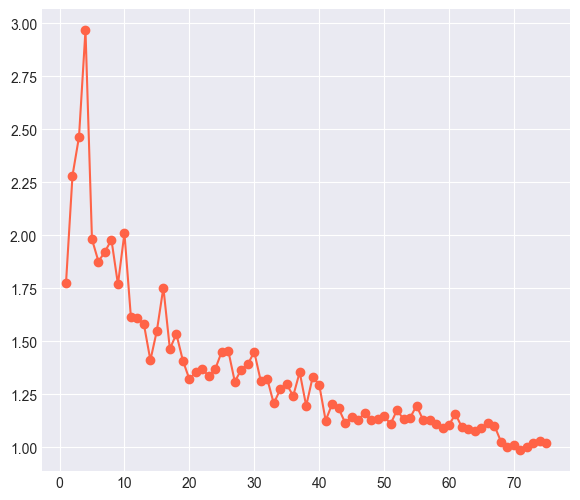

In [12]:
# --- 6. Visualizing Testing Phase Metrics (Graphs) ---

try:
    # Use the same cleaned DataFrame 'df' from above
    df['epoch'] = pd.to_numeric(df['epoch'])

    plt.figure(figsize=(15, 6))

    # Subplot 1: Validation/Testing Loss
    plt.subplot(1, 2, 1)
    # The val/box_loss and val/mask_loss are the key components for segmentation validation loss
    plt.plot(df['epoch'], df['val/box_loss'], label='Validation Box Loss', marker='o', linestyle='-', color='#FF6347') # Tomato Red
    plt.plot(df['epoch'], df['val/mask_loss'], label='Validation Mask Loss', marker='o', linestyle='-', color='#8A2BE2') # Blue Violet

    plt.title('Validation/Testing Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.tight_layout()

    # Subplot 2: mAP Metrics
    plt.subplot(1, 2, 2)
    # mAP(M) is for Masks
    plt.plot(df['epoch'], df['metrics/mAP50(M)'], label='mAP@0.5 (Masks)', marker='x', linestyle='--', color='#3CB371') # Medium Sea Green
    plt.plot(df['epoch'], df['metrics/mAP50-95(M)'], label='mAP@0.5:0.95 (Masks)', marker='x', linestyle='--', color='#1E90FF') # Dodger Blue

    plt.title('Validation mAP vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('mAP Score')
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.gca().set_ylim([0, 1]) # mAP values are between 0 and 1

    plt.tight_layout()
    plt.show()

except NameError:
    print("DataFrame 'df' was not created. Check for file path errors.")
except Exception as e:
    print(f"An error occurred during plotting: {e}")

print("-" * 50)

In [14]:
# --- 7. Save the Weights Separately ---
import shutil
import os

RUN_DIR = 'runs/segment/path_segmentation_run_s_opt7'
BEST_WEIGHTS_SOURCE = os.path.join(RUN_DIR, 'weights', 'best.pt')

FINAL_WEIGHTS_DIR = 'final_robot_weights'
FINAL_WEIGHTS_PATH = os.path.join(FINAL_WEIGHTS_DIR, 'best_path_segmentation_model.pt')

# Create the destination folder
os.makedirs(FINAL_WEIGHTS_DIR, exist_ok=True)

print(f"📂 Looking for weights in: {BEST_WEIGHTS_SOURCE}")

if os.path.exists(BEST_WEIGHTS_SOURCE):
    shutil.copyfile(BEST_WEIGHTS_SOURCE, FINAL_WEIGHTS_PATH)
    print("✅ Model Training Complete!")
    print(f"🏆 The best model weights have been saved to: **{FINAL_WEIGHTS_PATH}**")
else:
    # Diagnostic: Let's see what is actually in that folder if it fails
    print(f"❌ Error: Could not find weights at {BEST_WEIGHTS_SOURCE}")
    if os.path.exists(os.path.dirname(BEST_WEIGHTS_SOURCE)):
        print(f"Contents of weights folder: {os.listdir(os.path.dirname(BEST_WEIGHTS_SOURCE))}")
    else:
        print("The entire 'weights' directory seems to be missing. Check your training logs for errors.")

📂 Looking for weights in: runs/segment/path_segmentation_run_s_opt7/weights/best.pt
✅ Model Training Complete!
🏆 The best model weights have been saved to: **final_robot_weights/best_path_segmentation_model.pt**
